In [618]:
import time
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

tf.disable_v2_behavior()

In [619]:
dataset_X = scipy.io.loadmat('./dataset/timeseries/Trace_data.mat')['data']
dataset_Y = scipy.io.loadmat('./dataset/timeseries/Trace_label.mat')['label'][0]

In [634]:
X, Y = [], []

class_1 = 1
class_2 = 4

for i in range(len(dataset_Y)):
  if dataset_Y[i] == class_1 or dataset_Y[i] == class_2:
    X.append(dataset_X[i][:200])
    Y.append(dataset_Y[i])

X = np.array(X)
Y = np.array(Y)

In [635]:
Y = np.where(Y == class_2, -1, 1)

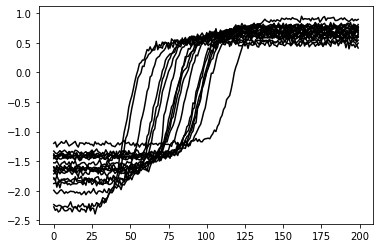

In [636]:
tmp = np.where(Y == -1)[0]
for i in range(len(tmp)):
  plt.plot(X[tmp[i]], 'k')
plt.show()

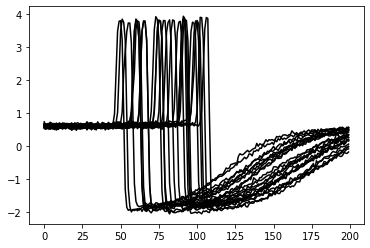

In [637]:
tmp = np.where(Y == 1)[0]
for i in range(len(tmp)):
  plt.plot(X[tmp[i]], 'k')

In [638]:
Y = np.array(Y).reshape(-1, 1)

In [639]:
print(np.shape(X))

(43, 200)


In [642]:
train_cnt = 30

train_index = np.random.choice(len(X), size=train_cnt, replace=False)
test_index = [x for x in np.arange(0, len(X)) if x not in train_index]

train_X = X[train_index]
train_Y = Y[train_index]

test_X = X[test_index]
test_Y = Y[test_index]


print(train_index)
print(test_index)

[ 1 37 23 16  0 14 27 21  5 20 28 38 33  6 40 30 11 17 15 41 34 10 42 32
 39  3 35 31 36  7]
[2, 4, 8, 9, 12, 13, 18, 19, 22, 24, 25, 26, 29]


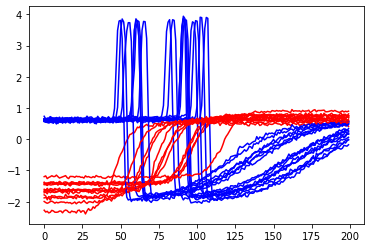

In [643]:
for i in range(len(train_X)):
  plt.plot(train_X[i].ravel(), 'b' if train_Y[i] == 1 else 'r')
plt.show()

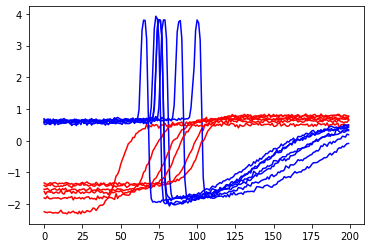

In [644]:
for i in range(len(test_X)):
  plt.plot(test_X[i].ravel(), 'b' if test_Y[i] == 1 else 'r')
plt.show()

In [646]:
BATCH_SIZE = int(np.shape(train_X)[0] / 2)
# BATCH_SIZE = train_cnt
ITER = 5
LR = 0.01
GAMMA = 1.8

In [647]:
x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='train_X')
y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='train_Y')

b = tf.Variable(tf.random_uniform(shape=[1, BATCH_SIZE]))

pred_x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='prediction_X')

test_x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='test_X')
test_y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='test_Y')

In [648]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [649]:
gamma = tf.constant(GAMMA)
dtw_distances = tf.py_function(func=_dtw, inp=[x, x], Tout=[tf.float32 for i in range(BATCH_SIZE)])

kernel = tf.exp(-tf.multiply(gamma, dtw_distances))

In [650]:
first_term = tf.reduce_sum(b)

b_vec_cross = tf.matmul(tf.transpose(b), b)
train_Y_cross = tf.matmul(y, tf.transpose(y))
second_term = tf.reduce_sum(
    tf.multiply(kernel, tf.multiply(b_vec_cross, train_Y_cross))
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [651]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[x, pred_x], Tout=[tf.float32 for i in range(BATCH_SIZE)])
pred_kernel = tf.exp(-tf.multiply(gamma, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y)), tf.float32))

In [652]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[x, test_x], Tout=[tf.float32 for i in range(BATCH_SIZE)])
test_kernel = tf.exp(-tf.multiply(gamma, test_dtw_distances))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(y), b), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_y)), tf.float32))

In [653]:
optimizer = tf.train.GradientDescentOptimizer(LR)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

In [654]:
start = time.time()

loss_vec = []
batch_accuracy = []

for i in range(ITER):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(len(train_X), size=BATCH_SIZE, replace=False)
  rand_X = train_X[rand_index]
  rand_Y = train_Y[rand_index]

  sess.run(train, feed_dict={x: rand_X, y: rand_Y})
  print(b.eval(sess))
  temp_loss = sess.run(loss, feed_dict={x: rand_X, y: rand_Y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={x: rand_X, y: rand_Y, pred_x: rand_X})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
[[0.968806   0.7331138  0.7886082  0.8568992  0.71383053 0.87634003
  0.04532808 0.91775125 0.823958   0.70681834 0.15034468 0.37485987
  0.9801781  0.8391264  0.01053364]]
accuracy : 0.93333334
loss: -1.8253903
time : 41.63399791717529
Step #2
[[0.95942706 0.7284451  0.78283596 0.8497607  0.70954764 0.8688107
  0.05442139 0.9093926  0.8174756  0.7026804  0.1573377  0.37736264
  0.97057456 0.83234286 0.0203217 ]]
accuracy : 0.8666667
loss: -1.9009123
time : 41.458001375198364
Step #3
[[0.950238   0.72387594 0.7771787  0.842765   0.7053562  0.86143404
  0.06333101 0.9012047  0.81112605 0.69862616 0.16419034 0.37981528
  0.96116304 0.825696   0.02991473]]
accuracy : 0.8
loss: -1.9750495
time : 43.071001052856445
Step #4
[[0.9412332  0.7193983  0.771635   0.8359082  0.7012466  0.85420525
  0.0720624  0.8931781  0.8049035  0.6946523  0.17090613 0.382219
  0.95193976 0.81917983 0.03931643]]
accuracy : 0.8666667
loss: -2.0450659
time : 45.40838384628296
Step #5
[[0.9324085  0.7150081

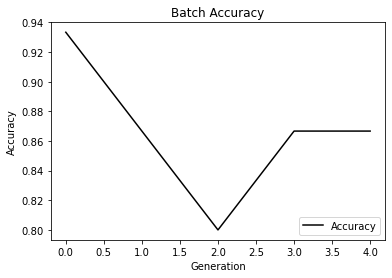

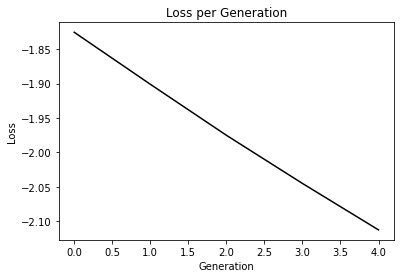

In [655]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [657]:
test_preds = sess.run(test_prediction,
                      feed_dict={
                          x: train_X[rand_index],
                          y: train_Y[rand_index],
                          test_x: test_X
                      })

In [658]:
test_preds = np.squeeze(test_preds)
_test_Y = np.squeeze(test_Y)

colors = []
cnt = 0
for i in range(len(test_preds)):
  if test_preds[i] == _test_Y[i]:
    cnt += 1
    colors.append('b')

  else:
    colors.append('r')

print(cnt)
print(cnt / len(test_preds))

10
0.7692307692307693


## Influence function

### Gradient for target data

In [660]:
inf_target_x = tf.placeholder(shape=[None, None], dtype=tf.float32, name='train_X')
inf_dtw_distances = tf.py_function(func=_dtw, inp=[x, inf_target_x], Tout=[tf.float32 for i in range(BATCH_SIZE)])
inf_kernel = tf.exp(-tf.multiply(gamma, inf_dtw_distances))

inf_first_term = tf.reduce_sum(b)

inf_b_vec_cross = tf.matmul(tf.transpose(b), b)
inf_train_Y_cross = tf.matmul(y, tf.transpose(y))
inf_second_term = tf.reduce_sum(
    tf.multiply(inf_kernel, tf.multiply(inf_b_vec_cross, inf_train_Y_cross))
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))

### test data gradient

In [661]:
z_grad_op = tf.gradients(inf_loss, [b])
z_hess_op = tf.hessians(loss, [b])

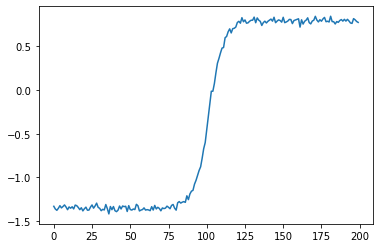

In [662]:
test_idx = 4
plt.plot(test_X[test_idx])
plt.show()

In [664]:
z_test_grad = sess.run(z_grad_op, feed_dict={x: train_X[rand_index], y: train_Y[rand_index], inf_target_x: [test_X[test_idx]]})
z_test_grad = np.squeeze(z_test_grad)

In [666]:
z_hess = sess.run(z_hess_op, feed_dict={x: train_X[rand_index], y: train_Y[rand_index]})
z_hess = np.squeeze(z_hess)
z_inv_hess = np.linalg.inv(z_hess)

### Get influence value on test data

In [677]:
infs = []
for i in range(np.shape(train_X[rand_index])[0]):
  z_train_grad = sess.run(z_grad_op, feed_dict={x: train_X[rand_index], y: train_Y[rand_index], inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)

  z_hess_grad = np.dot(z_inv_hess, z_train_grad)
  inf_value = -np.dot(z_test_grad, z_hess_grad)
  infs.append((i, inf_value))

infs = sorted(infs, key=lambda x: x[1])


In [675]:
train_X[rand_index][0]

array([ 6.3761560e-01,  5.8507817e-01,  6.2313348e-01,  6.2931901e-01,
        6.4103238e-01,  6.4420898e-01,  6.2027431e-01,  6.2943691e-01,
        6.9316656e-01,  6.2957646e-01,  6.2534782e-01,  6.5990860e-01,
        6.3392296e-01,  6.5536868e-01,  6.0337362e-01,  6.4974072e-01,
        6.6807118e-01,  6.8640165e-01,  6.6711563e-01,  6.6858264e-01,
        6.4354493e-01,  6.5699702e-01,  6.2027340e-01,  6.4881909e-01,
        6.9399330e-01,  6.3277646e-01,  6.5121460e-01,  6.6965274e-01,
        6.3908066e-01,  6.0987792e-01,  5.9914015e-01,  6.1850516e-01,
        6.4624002e-01,  5.9949118e-01,  5.9467176e-01,  6.1237425e-01,
        6.3778116e-01,  5.9161742e-01,  6.9696223e-01,  6.2326569e-01,
        6.6850382e-01,  6.1649806e-01,  6.5323791e-01,  6.3485049e-01,
        6.3918827e-01,  6.6292545e-01,  6.8666264e-01,  6.3709976e-01,
        6.5862893e-01,  6.8456036e-01,  6.0602785e-01,  5.5025512e-01,
        6.3813132e-01,  6.3954667e-01,  6.4380684e-01,  6.8424381e-01,
      

In [684]:
print(np.shape(infs))
print(infs)

(15, 2)
[(13, -8.928463), (9, -8.617865), (5, -7.4997325), (3, -7.4997067), (6, -7.4995985), (1, -7.499598), (4, -7.4995575), (12, -7.499547), (14, -7.4995294), (11, -7.499402), (2, -7.4993277), (10, -6.5746737), (8, -6.5265684), (7, -5.4494457), (0, -5.2490606)]


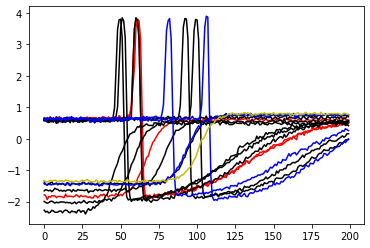

In [682]:
for i in range(len(infs)):
  idx = int(infs[i][0])
  color = 'k'
  if i < 3:
    color = 'r'
  elif i > 11:
    color = 'b'

  plt.plot(train_X[rand_index][idx], color)

plt.plot(test_X[test_idx], 'y')
plt.show()

### Get influence value on train data

In [558]:
print(z_test_grad)

[-1.0001898  -0.99981016 -0.99981016 -0.99981016 -1.0001898  -0.99967396
 -0.9998054  -0.9996345  -1.0001898  -0.9998083  -0.9997876  -1.0001898
 -1.0001898  -0.9997993  -0.99981016 -0.9997356  -0.99981016 -1.0001898
 -0.99981016 -0.99981016]


In [559]:
loo_infs = []
for i in range(np.shape(train_X)[0]):
  z_train_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)
  z_hess_grad = np.dot(z_inv_hess, z_train_grad)
  inf_value = -np.dot(z_train_grad, z_hess_grad)
  loo_infs.append((i, inf_value))

In [560]:
loo_infs = np.absolute(loo_infs)
print(loo_infs)

[[ 0.         25.67647934]
 [ 1.          8.34867096]
 [ 2.          8.45496368]
 [ 3.          8.34404182]
 [ 4.         26.1851635 ]
 [ 5.          8.8975029 ]
 [ 6.          8.65518951]
 [ 7.         11.59383202]
 [ 8.         18.1217308 ]
 [ 9.         10.87485981]
 [10.          9.70298958]
 [11.         25.46894264]
 [12.         12.39640427]
 [13.          8.89560509]
 [14.          8.97196674]
 [15.          8.48952675]
 [16.          8.7679882 ]
 [17.         24.52728844]
 [18.          8.32010269]
 [19.          8.92918777]]


[array([18.        ,  8.32010269]), array([3.        , 8.34404182]), array([1.        , 8.34867096]), array([2.        , 8.45496368]), array([15.        ,  8.48952675]), array([6.        , 8.65518951]), array([16.       ,  8.7679882]), array([13.        ,  8.89560509]), array([5.       , 8.8975029]), array([19.        ,  8.92918777]), array([14.        ,  8.97196674]), array([10.        ,  9.70298958]), array([ 9.        , 10.87485981]), array([ 7.        , 11.59383202]), array([12.        , 12.39640427]), array([ 8.       , 18.1217308]), array([17.        , 24.52728844]), array([11.        , 25.46894264]), array([ 0.        , 25.67647934]), array([ 4.       , 26.1851635])]


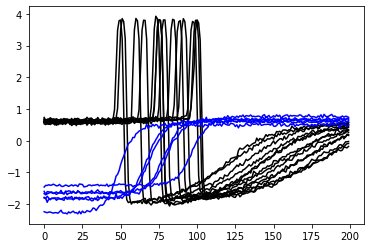

In [561]:
loo_infs = sorted(loo_infs, key=lambda x: x[1])
print(loo_infs)

for i in range(len(loo_infs)):
  idx = int(loo_infs[i][0])
  color = 'b'
  if i < 14:
    color = 'k'

  plt.plot(train_X[idx], color)

plt.show()

In [615]:
z_hess_op2 = tf.hessians(inf_loss, [b])

z_test_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [test_X[test_idx]]})
z_test_grad = np.squeeze(z_test_grad)

infs = []
for i in range(np.shape(train_X)[0]):
  z_train_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)

  z_train_hess = sess.run(z_hess_op2, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_hess = np.squeeze(z_train_hess)
  z_train_hess = np.diag(z_train_hess)
  z_train_hess = np.identity(20) - z_train_hess
  z_train_inv_hess = np.linalg.inv(z_train_hess)

  z_hess_grad = np.dot(z_train_inv_hess, z_train_grad)
  inf_value = -np.dot(z_test_grad, z_hess_grad)
  infs.append((i, inf_value))

infs = sorted(infs, key=lambda x: x[1])

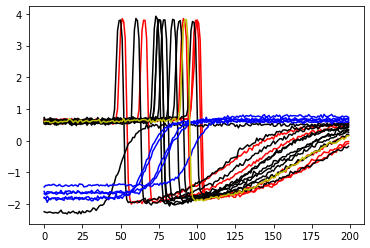

In [616]:
for i in range(len(infs)):
  idx = int(infs[i][0])
  color = 'k'
  if i < 5:
    color = 'r'
  elif i > 14:
    color = 'b'

  plt.plot(train_X[idx], color)

plt.plot(test_X[test_idx], 'y')
plt.show()

In [597]:
z_hess_op2 = tf.hessians(inf_loss, [b])

z_test_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [test_X[test_idx]]})
z_test_grad = np.squeeze(z_test_grad)

infs = []

s_test = 0
for j in range(20):
  s_test_j = z_test_grad
  print(j)

  for i in range(np.shape(train_X)[0]):

    z_train_hess = sess.run(z_hess_op2, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
    z_train_hess = np.squeeze(z_train_hess)
    z_train_hess = np.diag(z_train_hess)
    z_train_hess = np.identity(20) - z_train_hess
    s_test_j = z_test_grad + np.matmul(z_train_hess, s_test_j)

  s_test += s_test_j

s_test = s_test / 20

for i in range(np.shape(train_X)[0]):
  z_train_grad = sess.run(z_grad_op, feed_dict={x: train_X, y: train_Y, inf_target_x: [train_X[i]]})
  z_train_grad = np.squeeze(z_train_grad)

  inf_value = -np.matmul(s_test, z_train_grad)
  infs.append((i, inf_value))

infs = sorted(infs, key=lambda x: x[1])

0


KeyboardInterrupt: 

In [596]:
print(infs)

[(4, -27.764370486913183), (0, -27.601083314210236), (11, -27.533704133658905), (17, -27.238849136891595), (8, -24.736126429422644), (12, -21.232148720989255), (14, -17.684211478302505), (5, -17.56460568927127), (13, -17.56150247354791), (16, -17.33672513475048), (6, -17.109635842485595), (15, -16.689704151279958), (2, -16.578799474821324), (18, -15.755649454674211), (3, -15.242116720336053), (1, -15.20724136116947), (19, -13.677259206680993), (10, -12.681704013060997), (9, -11.617872949008794), (7, -11.086187110573597)]


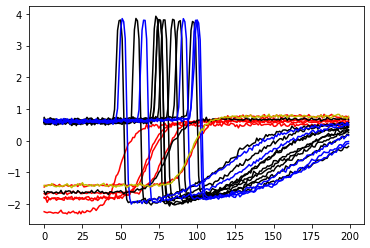

In [594]:
for i in range(len(infs)):
  idx = int(infs[i][0])
  color = 'k'
  if i < 5:
    color = 'r'
  elif i > 14:
    color = 'b'

  plt.plot(train_X[idx], color)

plt.plot(test_X[test_idx], 'y')
plt.show()